In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize, curve_fit
from functools import partial
from tqdm import tqdm


from springlock import GasSpringlock

In [2]:
# Load in the data and set up the model
spring_data = pd.read_csv("springs.csv")

# Dimensions to be used for all springlock systems
weapon_mass = 0.200 # kg
weapon_radius = 30 # mm
weapon_arm_length = 150 # mm
weapon_arm_mass = 0.100 # kg
spring_arm_mass = 0.020 # kg

# Target performance
target_weapon_speed = 10 # m/s
max_spring_length = 120 # mm

units = {
    'mass_units': 'kg',
    'length_units': 'mm',
    'angle_units': 'deg',
    'pressure_units': 'bar',
    'area_units': 'mm^2',
    'volume_units': 'ml',
    'speed_units': 'm/s',
}


In [3]:
# Create all of the springlocks based off of the data
for i, row in spring_data.iterrows():
    name = f'{row["Manufacturer"]} {row["Model"]}'
    arm_length = row['Stroke'] / 2
    
    initial_length = row['Initial Length']
    final_length = row['Initial Length'] - row['Stroke']
    initial_pressure = row['Initial Pressure']
    initial_force = row['Initial Force']
    final_force = row['Final Force (iso)']

    springlock = GasSpringlock(
        name=name,
        weapon_mass=weapon_mass,
        weapon_radius=weapon_radius,
        weapon_arm_length=weapon_arm_length,
        weapon_arm_mass=weapon_arm_mass,
        spring_arm_length=arm_length,
        spring_arm_mass=spring_arm_mass,
        spring_initial_length=initial_length,
        spring_final_length=final_length,
        spring_initial_pressure=initial_pressure,
        spring_initial_force=initial_force,
        spring_final_force=final_force,
        **units,
    )

    # Save the performance data to the dataframe
    spring_data.loc[i, 'Final Length'] = row['Initial Length'] - row['Stroke']
    spring_data.loc[i, 'Initial Aspect Ratio'] = row['Initial Length'] / row['Diameter']
    spring_data.loc[i, 'Final Aspect Ratio'] = (row['Initial Length'] - row['Stroke']) / row['Diameter']
    spring_data.loc[i, 'Initial Volume'] = springlock.spring_initial_volume
    spring_data.loc[i, 'Final Volume'] = springlock.spring_final_volume
    spring_data.loc[i, 'Max Potential Energy'] = abs(springlock.max_potential_energy)
    spring_data.loc[i, 'Max Torque'] = springlock.max_torque
    spring_data.loc[i, 'Max Radial Force'] = springlock.max_radial_force
    spring_data.loc[i, 'Max Tangential Force'] = springlock.max_tangential_force
    spring_data.loc[i, 'Max Tip Speed'] = springlock.max_tip_speed
    spring_data.loc[i, 'Max Spring Speed'] = springlock.max_spring_speed
    spring_data.loc[i, 'Tip Speed per Unit Mass'] = springlock.max_tip_speed / row['Mass']
    spring_data.loc[i, 'Energy per Unit Mass'] = abs(springlock.max_potential_energy) / row['Mass']






Correlations:
  - Final Force (iso): -0.71


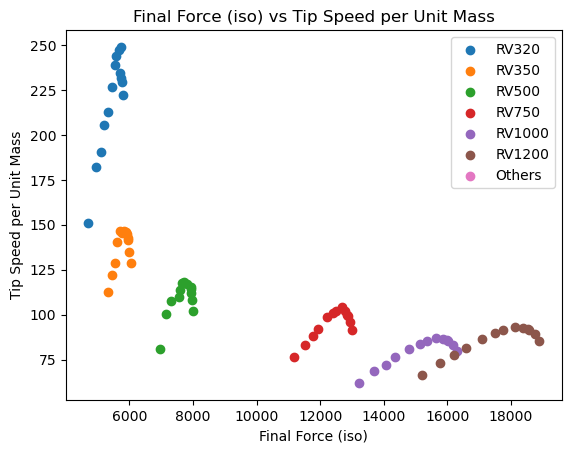

  - Mass: -0.61


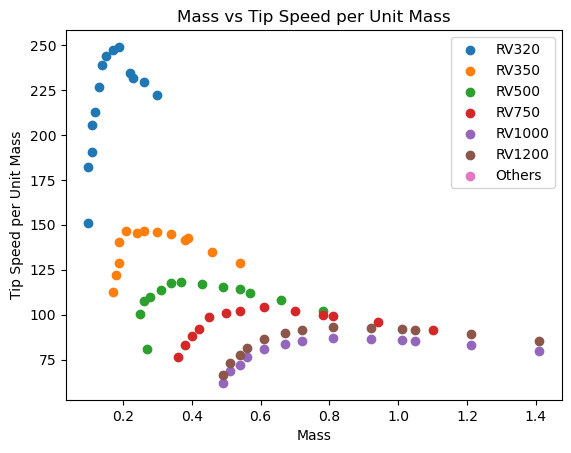

  - Final Aspect Ratio: 0.53


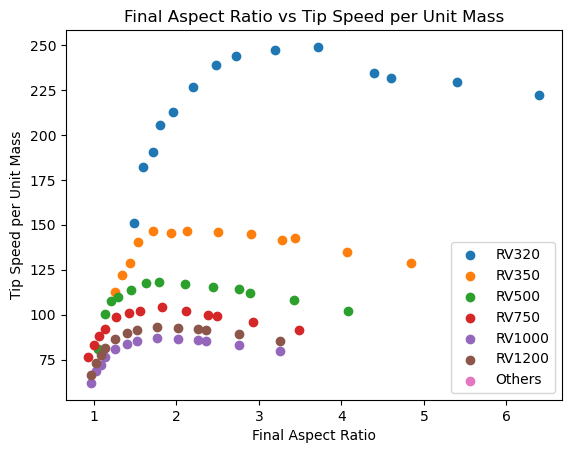

  - Initial Aspect Ratio: 0.47


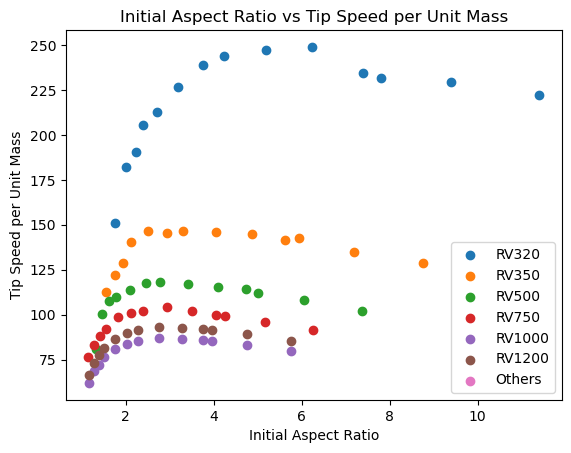

  - Final Volume: -0.40


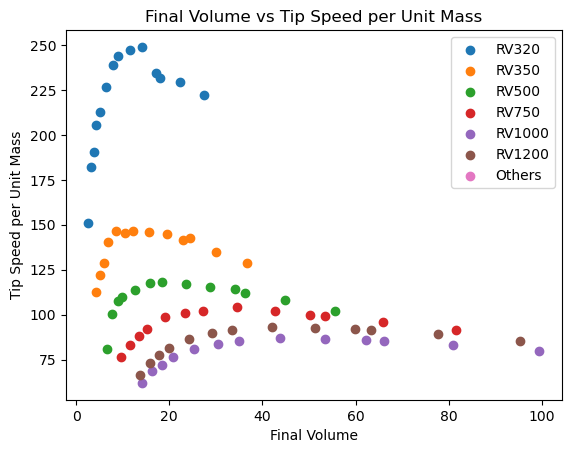

  - Initial Volume: -0.38


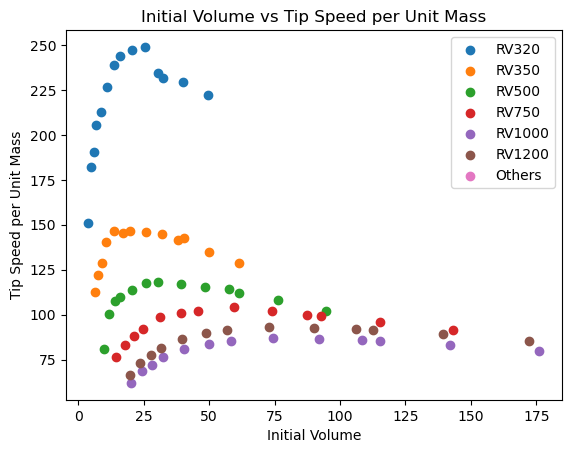

  - Max Potential Energy: -0.30


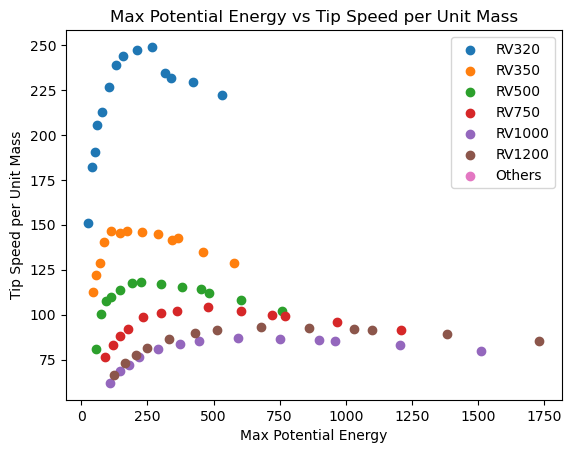

  - Max Tip Speed: -0.30


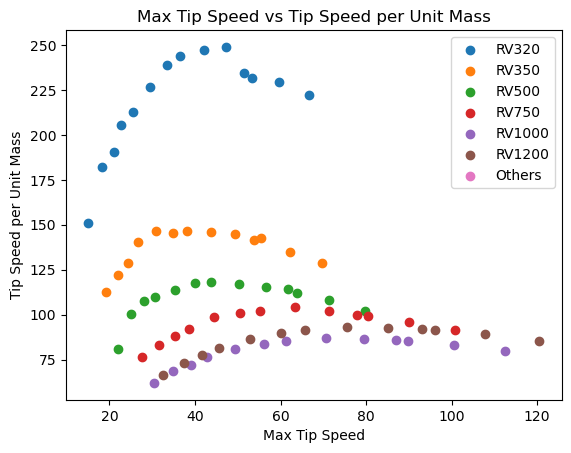

  - Stroke: 0.07


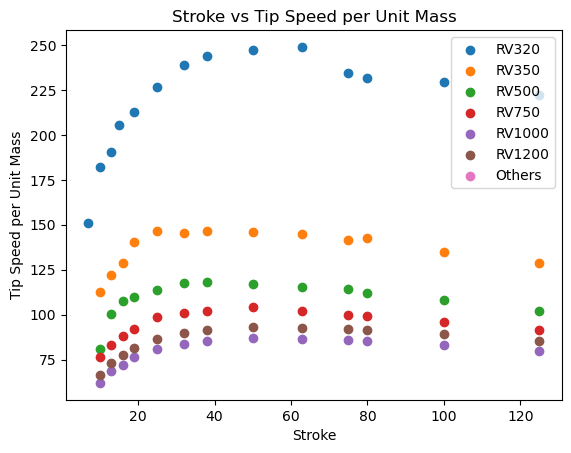

  - Initial Length: 0.05


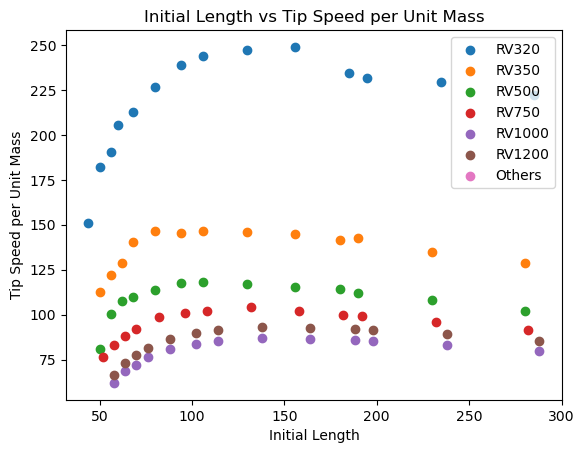

  - Final Length: 0.02


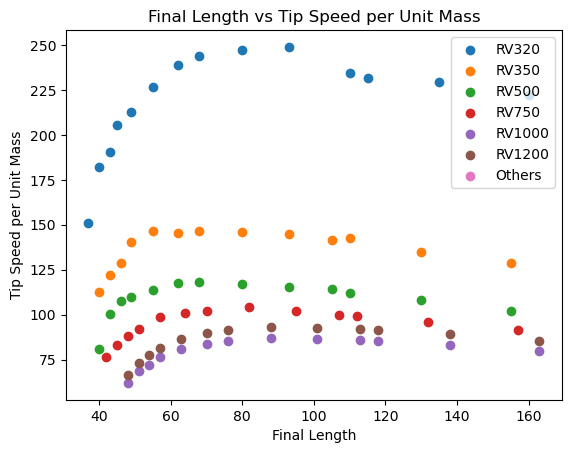

In [4]:
# Find the column with the best correlation to the energy per unit mass
correlations = []
target_column = 'Tip Speed per Unit Mass'

# Make some subcatregories for the columns for the different spring types
categories = {
    'RV320': spring_data[spring_data['Model'].str.contains('RV320')],
    'RV350': spring_data[spring_data['Model'].str.contains('RV350')],
    'RV500': spring_data[spring_data['Model'].str.contains('RV500')],
    'RV750': spring_data[spring_data['Model'].str.contains('RV750')],
    'RV1000': spring_data[spring_data['Model'].str.contains('RV1000')],
    'RV1200': spring_data[spring_data['Model'].str.contains('RV1200')],
    'Others': spring_data[~spring_data['Model'].str.contains('RV320|RV350|RV500|RV750|RV1000|RV1200')]
}

for column in ('Stroke', 'Initial Length', 'Initial Volume', 'Final Volume', 'Final Length', 'Final Force (iso)', 'Mass', 'Max Potential Energy', 'Max Tip Speed', 'Initial Aspect Ratio', 'Final Aspect Ratio'):
    correlation = np.corrcoef(spring_data[target_column], spring_data[column])[0, 1]
    correlations.append((correlation, column))
    

correlations.sort(key=lambda x: abs(x[0]), reverse=True)

print('Correlations:')
for correlation, column in correlations:
    print(f'  - {column}: {correlation:.2f}')

    # Plot a scatter plot for the column
    for category_name, category in categories.items():
        plt.scatter(category[column], category[target_column], label=category_name)
    plt.xlabel(column)
    plt.ylabel(target_column)
    plt.title(f'{column} vs {target_column}')
    plt.legend()
    plt.show()




In [5]:
# Find all the suitable springs
options = spring_data[spring_data['Max Tip Speed'] > target_weapon_speed]
options = options[options['Initial Length'] <= max_spring_length]
options = options[options['Max Spring Speed'] <= options['Max Speed']]

# Sort the options by mass
options.sort_values(by='Mass', inplace=True)

print(f'Found {len(options)} suitable springs')
options[['Manufacturer', 'Model', 'Max Tip Speed', 'Tip Speed per Unit Mass', 'Mass', 'Initial Length', 'Max Spring Speed']]

Found 22 suitable springs


,Manufacturer,Model,Max Tip Speed,Tip Speed per Unit Mass,Mass,Initial Length,Max Spring Speed
0,Special Springs,RV320-007-C,15.085993,150.859925,0.10,44,0.275671
1,Special Springs,RV320-010-C,18.240996,182.409960,0.10,50,0.476182
2,Special Springs,RV320-013-C,20.951257,190.465971,0.11,56,0.710536
3,Special Springs,RV320-015-C,22.585702,205.324567,0.11,60,0.883288
4,Special Springs,RV320-019-C,25.552502,212.937514,0.12,68,1.264204
14,Special Springs,RV350-010-B,19.134323,112.554843,0.17,50,0.497660
15,Special Springs,RV350-013-B,21.939729,121.887386,0.18,56,0.740875
16,Special Springs,RV350-016-B,24.442900,128.646842,0.19,62,1.014655
17,Special Springs,RV350-019-B,26.713245,140.596026,0.19,68,1.315176
28,Special Springs,RV500-013-B,25.115839,100.463356,0.25,56,0.848665
